In [ ]:
pip install -r requirements.txt

In [3]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import collections
import re
import string

### Read data

In [4]:
data = pd.read_csv('imdb_labelled.tsv', header = None, delimiter='\t')

In [5]:
data.columns = ['Text', 'Label']

In [ ]:
data.head()

In [ ]:
data.Label.unique()

In [ ]:
data.shape

In [9]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [10]:
data['Pos']= pos
data['Neg']= neg

In [ ]:
data.head()

### Clean data

In [12]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [ ]:
import nltk
nltk.download('punkt')

In [14]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean] 

In [15]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens] 

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [17]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [18]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [19]:
result = [' '.join(sen) for sen in filtered_words] 

In [20]:
data['Text_Final'] = result

In [21]:
data['tokens'] = filtered_words

In [22]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]

In [ ]:
data[:4]

### Split data into test and train

In [24]:
data_train, data_test = train_test_split(data, test_size=0.20, random_state=42)

In [ ]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

In [ ]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

### Load Google News Word2Vec model

In [27]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [28]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

### Get Embeddings

In [29]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [30]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

### Tokenize and Pad sequences

In [ ]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

In [32]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
type(data_test["Text_Final"])

### Define CNN

In [35]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [36]:
label_names = ['Pos', 'Neg']

In [37]:
y_train = data_train[label_names].values

In [38]:
x_train = train_cnn_data
y_tr = y_train

In [ ]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

### Train CNN

1/1 [==============================] - 1s 714ms/step
0.6533333333333333
Epoch 1/2
16/16 [==============================] - 4s 240ms/step - loss: 0.5524 - acc: 0.8104 - val_loss: 0.5191 - val_acc: 0.8000
Epoch 2/2
1/1 [==============================] - 0s 423ms/step
0.7733333333333333
Epoch 1/3
16/16 [==============================] - 3s 206ms/step - loss: 0.2225 - acc: 0.9312 - val_loss: 0.4444 - val_acc: 0.8167
Epoch 2/3
16/16 [==============================] - 3s 191ms/step - loss: 0.1123 - acc: 0.9777 - val_loss: 0.3552 - val_acc: 0.8000
Epoch 3/3
1/1 [==============================] - 0s 438ms/step
0.8066666666666666


Text(0.5, 1.0, 'epochs vs accuracy')

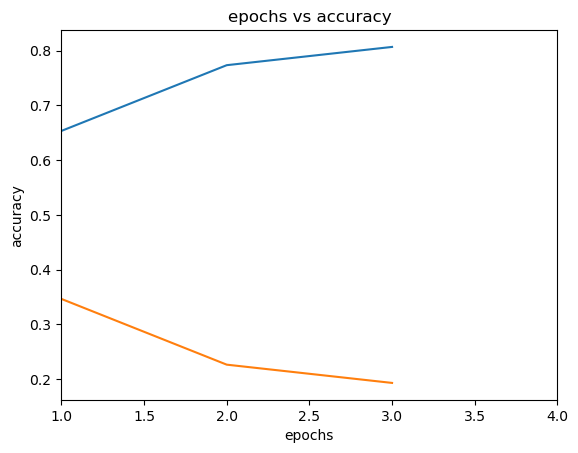

In [40]:
batch_size = 34
epoch=3
x_accuracy=[]
x_loss=[]
for num_epochs in range(1,epoch+1):
    hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
    predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)
    labels = [1, 0]
    prediction_labels=[]
    for p in predictions:
        prediction_labels.append(labels[np.argmax(p)])
    print(sum(data_test.Label==prediction_labels)/len(prediction_labels))
    x_accuracy.append(sum(data_test.Label==prediction_labels)/len(prediction_labels))
    x_loss.append(1-sum(data_test.Label==prediction_labels)/len(prediction_labels))
    if(num_epochs!=epoch+1):
        prediction_labels=[]
x1 = []
for i in range(1,epoch+1):
    x1.append(i)

# plotting the line 1 points 
plt.plot(x1, x_accuracy, label = "line 1")
  
# line 2 points
x2 = []
for i in range(1,epoch+1):
    x2.append(i)

# plotting the line 2 points 
plt.plot(x2, x_loss, label = "line 2")
  
# naming the x axis
plt.xlabel('epochs')
plt.xlim(1,epoch+1)
# naming the y axis
plt.ylabel('accuracy')
# giving a title to my graph
plt.title('epochs vs accuracy')



### Test CNN

In [41]:
labels = [1, 0]

In [ ]:
data_test.Label.value_counts()

In [ ]:
print(data_test.Label)

In [47]:
review=[input()]
test_seq = tokenizer.texts_to_sequences(review)
test_cnndata = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
review_result=model.predict(test_cnndata, batch_size=1024, verbose=1)
if(review_result[0][0]>review_result[0][1]):
    print("positive value:"+str(review_result[0][0]))
else:
    print('negative:'+str(review_result[0][1]))
review[0][0]
BAR_WIDTH = 1


    

Amazing Product! Best part is design
1/1 [==============================] - 0s 40ms/step
positive value:0.9950602
